In [1]:
import sqlite3
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from sklearn import tree, preprocessing

In [3]:
con = sqlite3.connect("../../Bootcamp_Repo/Homework/Project 3/FPA_FOD_20210617.sqlite")

cur = con.cursor()

In [4]:
cur.execute("SELECT * FROM Fires");
names = list(map(lambda x: x[0], cur.description))
print(names)

['FOD_ID', 'FPA_ID', 'SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM', 'NWCG_REPORTING_AGENCY', 'NWCG_REPORTING_UNIT_ID', 'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT', 'SOURCE_REPORTING_UNIT_NAME', 'LOCAL_FIRE_REPORT_ID', 'LOCAL_INCIDENT_ID', 'FIRE_CODE', 'FIRE_NAME', 'ICS_209_PLUS_INCIDENT_JOIN_ID', 'ICS_209_PLUS_COMPLEX_JOIN_ID', 'MTBS_ID', 'MTBS_FIRE_NAME', 'COMPLEX_NAME', 'FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_DOY', 'DISCOVERY_TIME', 'NWCG_CAUSE_CLASSIFICATION', 'NWCG_GENERAL_CAUSE', 'NWCG_CAUSE_AGE_CATEGORY', 'CONT_DATE', 'CONT_DOY', 'CONT_TIME', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE', 'LONGITUDE', 'OWNER_DESCR', 'STATE', 'COUNTY', 'FIPS_CODE', 'FIPS_NAME', 'region_id']


In [ ]:
# cur.execute('SELECT FIRE_YEAR,NWCG_GENERAL_CAUSE,LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE,FIRE_SIZE FROM Fires limit 10')
# cur.fetchall()

In [5]:
df = pd.read_sql_query('SELECT FIRE_YEAR,NWCG_GENERAL_CAUSE,LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE,FIRE_SIZE FROM Fires', con).dropna()
df['DISCOVERY_DATE'] = pd.to_datetime(df['DISCOVERY_DATE'])
df.head()

,FIRE_YEAR,NWCG_GENERAL_CAUSE,LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE,FIRE_SIZE
0,2005,Power generation/transmission/distribution,40.036944,-121.005833,CA,2005-02-02,0.10
1,2004,Natural,38.933056,-120.404444,CA,2004-05-12,0.25
2,2004,Debris and open burning,38.984167,-120.735556,CA,2004-05-31,0.10
3,2004,Natural,38.559167,-119.913333,CA,2004-06-28,0.10
4,2004,Natural,38.559167,-119.933056,CA,2004-06-28,0.10


In [6]:
df['MONTH'] = pd.DatetimeIndex(df['DISCOVERY_DATE']).month
df['DAY_OF_WEEK'] = df['DISCOVERY_DATE'].dt.day_name()
df.head()

,FIRE_YEAR,NWCG_GENERAL_CAUSE,LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE,FIRE_SIZE,MONTH,DAY_OF_WEEK
0,2005,Power generation/transmission/distribution,40.036944,-121.005833,CA,2005-02-02,0.10,2,Wednesday
1,2004,Natural,38.933056,-120.404444,CA,2004-05-12,0.25,5,Wednesday
2,2004,Debris and open burning,38.984167,-120.735556,CA,2004-05-31,0.10,5,Monday
3,2004,Natural,38.559167,-119.913333,CA,2004-06-28,0.10,6,Monday
4,2004,Natural,38.559167,-119.933056,CA,2004-06-28,0.10,6,Monday


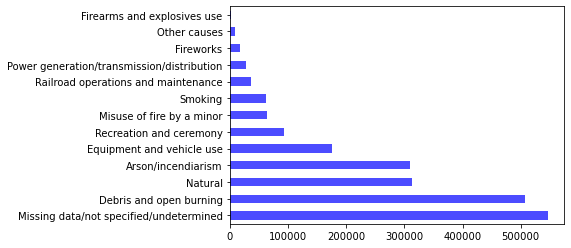

In [7]:
df['NWCG_GENERAL_CAUSE'].value_counts().plot(kind='barh',color='blue', alpha=0.7)
plt.show()

In [ ]:
# df.to_csv('cause_actual.csv', index = False)

### Combining Causes into 4 main categories increases the accuracy of the training

In [8]:
# def set_label(ctg):
#     cause = 0
#     natural = ['Naural']
#     accidental = ['Firearms and explosives use', 'Fireworks', 'Power generation/transmission/distribution',
#                   'Railroad operations and maintenance','Smoking','Misuse of fire by a minor','Recreation and ceremony',
#                   'Equipment and vehicle use','Debris and open burning']
#     malicious = ['Arson/incendiarism']
#     other = ['Missingdata/not specified/undetermined','Other causes']
#     if ctg in natural:
#         cause = 1
#     elif ctg in accidental:
#         cause = 2
#     elif ctg in malicious:
#         cause = 3
#     else:
#         cause = 4
#     return cause

In [9]:
# df['NWCG_GENERAL_CAUSE'] = df['NWCG_GENERAL_CAUSE'].apply(lambda x: set_label(x))
# df.head()

,FIRE_YEAR,NWCG_GENERAL_CAUSE,LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE,FIRE_SIZE,MONTH,DAY_OF_WEEK
0,2005,2,40.036944,-121.005833,CA,2005-02-02,0.10,2,Wednesday
1,2004,4,38.933056,-120.404444,CA,2004-05-12,0.25,5,Wednesday
2,2004,2,38.984167,-120.735556,CA,2004-05-31,0.10,5,Monday
3,2004,4,38.559167,-119.913333,CA,2004-06-28,0.10,6,Monday
4,2004,4,38.559167,-119.933056,CA,2004-06-28,0.10,6,Monday


In [10]:
# df = df[df['NWCG_GENERAL_CAUSE'] != 4]
# df.head()

,FIRE_YEAR,NWCG_GENERAL_CAUSE,LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE,FIRE_SIZE,MONTH,DAY_OF_WEEK
0,2005,2,40.036944,-121.005833,CA,2005-02-02,0.1,2,Wednesday
2,2004,2,38.984167,-120.735556,CA,2004-05-31,0.1,5,Monday
7,2005,2,40.968056,-122.433889,CA,2005-03-08,0.8,3,Tuesday
8,2005,2,41.233611,-122.283333,CA,2005-03-15,1.0,3,Tuesday
13,2004,2,38.433333,-120.510000,CA,2004-09-28,6.0,9,Tuesday


### Using One Hot Encoding to encode the cause list

In [ ]:
df = df[df['NWCG_GENERAL_CAUSE'] != 'Missingdata/not specified/undetermined']

df = df[df['NWCG_GENERAL_CAUSE'] != 'Other causes']

df.head(25)

In [ ]:
from sklearn import tree, preprocessing
le = preprocessing.LabelEncoder()
df['NWCG_GENERAL_CAUSE'] = le.fit_transform(df['NWCG_GENERAL_CAUSE'])
df.head()

In [ ]:
# df.to_csv('cause_encoded.csv', index = False)

### Alternate OneHot Encoding creating columns for cause values

In [ ]:
# from sklearn.preprocessing import OneHotEncoder as SklearnOneHotEncoder

# class OneHotEncoder(SklearnOneHotEncoder):
#     def __init__(self, **kwargs):
#         super(OneHotEncoder, self).__init__(**kwargs)
#         self.fit_flag = False

#     def fit(self, X, **kwargs):
#         out = super().fit(X)
#         self.fit_flag = True
#         return out

#     def transform(self, X, **kwargs):
#         sparse_matrix = super(OneHotEncoder, self).transform(X)
#         new_columns = self.get_new_columns(X=X)
#         d_out = pd.DataFrame(sparse_matrix.toarray(), columns=new_columns, index=X.index)
#         return d_out

#     def fit_transform(self, X, **kwargs):
#         self.fit(X)
#         return self.transform(X)

#     def get_new_columns(self, X):
#         new_columns = []
#         for i, column in enumerate(X.columns):
#             j = 0
#             while j < len(self.categories_[i]):
#                 new_columns.append(f'{column}_<{self.categories_[i][j]}>')
#                 j += 1
#         return new_columns

In [ ]:
# encoder = OneHotEncoder()
# encoder.fit_transform(df)

In [ ]:
# df.head()

In [11]:
df = df.astype({"DAY_OF_WEEK":'category', "STATE":'category'})
df["DAY_OF_WEEK"] = df["DAY_OF_WEEK"].cat.codes
df["STATE"] = df["STATE"].cat.codes
df.head()

,FIRE_YEAR,NWCG_GENERAL_CAUSE,LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE,FIRE_SIZE,MONTH,DAY_OF_WEEK
0,2005,2,40.036944,-121.005833,4,2005-02-02,0.1,2,6
2,2004,2,38.984167,-120.735556,4,2004-05-31,0.1,5,1
7,2005,2,40.968056,-122.433889,4,2005-03-08,0.8,3,5
8,2005,2,41.233611,-122.283333,4,2005-03-15,1.0,3,5
13,2004,2,38.433333,-120.510000,4,2004-09-28,6.0,9,5


In [12]:
df = df.drop(['DISCOVERY_DATE'], axis=1)
df.head()

,FIRE_YEAR,NWCG_GENERAL_CAUSE,LATITUDE,LONGITUDE,STATE,FIRE_SIZE,MONTH,DAY_OF_WEEK
0,2005,2,40.036944,-121.005833,4,0.1,2,6
2,2004,2,38.984167,-120.735556,4,0.1,5,1
7,2005,2,40.968056,-122.433889,4,0.8,3,5
8,2005,2,41.233611,-122.283333,4,1.0,3,5
13,2004,2,38.433333,-120.510000,4,6.0,9,5


In [13]:
X = df.drop(['NWCG_GENERAL_CAUSE'], axis=1).values
y = df['NWCG_GENERAL_CAUSE'].values

print("Shape: ", X.shape, y.shape)


Shape:  (1296745, 7) (1296745,)


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras.utils import to_categorical
import sklearn.ensemble as ske

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

In [16]:
clf_rf = ske.RandomForestClassifier(n_estimators=50)
clf_rf = clf_rf.fit(X_train, y_train)
print(clf_rf.score(X_test,y_test))

0.8265299827260015


In [ ]:
predictions = clf_rf.predict(X_test[:2000000])


In [ ]:
print(predictions)

In [ ]:
# Relabels the predictions from manual encoding
# label = []
# for i in predictions:
    
#     if i == 1 :
#         label.append('natural')
#     elif i == 2 :
#         label.append('accidental')
#     elif i == 3 :
#         label.append('malicious')
    

In [ ]:
# Relabels the predictions from One Hot encoding
label = []
for i in predictions:
    if i ==0:
        label.append('Arson/incendiarism')
    elif i == 1 :
        label.append('Debris and open burning')
    elif i == 2 :
        label.append('Equipment and vehicle use')
    elif i == 3 :
        label.append('Firearms and explosives use')
    elif i == 4:
        label.append('Fireworks')
    elif i == 5:
        label.append('Missing data/not specified/undetermined')
    elif i == 6:
        label.append('Misuse of fire by a minor')
    elif i == 7:
        label.append('Natural')
    elif i == 8:
        label.append('Power generation/transmission/distribution')
    elif i == 9:
        label.append('Railroad operations and maintenance')
    elif i == 10:
        label.append('Recreation and ceremony')
    elif i == 11:
        label.append('Smoking')




In [ ]:
print(label)

In [ ]:
# cause_predictions = pd.DataFrame(label).reset_index(drop=True)
# cause_predictions.to_csv('cause_predictions.csv', index = False)